In [1]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import tensorflow as tf

tf.__version__

'2.6.0'

In [3]:
import re
import matplotlib.pyplot as plt
import cv2

In [4]:
framObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [5]:
%%time

framObjTrain = LoadData(framObjTrain, 
                    imgPath = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign',
                    maskPath = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign',
                    shape = 256)
framObjTrain = LoadData(framObjTrain, 
                        imgPath = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant',
                        maskPath = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant',
                        shape = 256)
# framObjTrain = LoadData(framObjTrain, 
#                         imgPath = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal',
#                         maskPath = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal',
#                         shape = 256)

CPU times: user 7.88 s, sys: 899 ms, total: 8.78 s
Wall time: 15.5 s


In [6]:
for disease in os.listdir('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'):
    count = len(os.listdir('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/{}'.format(disease)))
    print('Total number of images for', disease, 'is:', count)

Total number of images for benign is: 891
Total number of images for normal is: 266
Total number of images for malignant is: 421


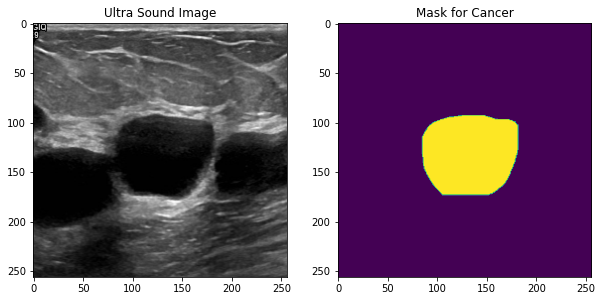

In [7]:
## display any random image
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][100])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][100])
plt.title('Mask for Cancer')
plt.show()

In [8]:
###########################################################################
#                                Model   Defination                       #
###########################################################################


# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [9]:
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

2021-12-05 01:14:08.836827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 01:14:08.981648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 01:14:08.982378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 01:14:08.983515: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
# class CustomSaver(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if score >= max(self.history):
#             print('saving checkpoint: ', score)
#             self.model.save('../working/cancer_bestqwk.h5')

In [11]:
filepath = '../working/my_best_model.hdf5'

In [12]:
from tensorflow.keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 30; batch_size = 32
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, 
                                   verbose=1, epsilon=0.0001)
early = EarlyStopping(monitor="val_accuracy", verbose=1,
                      patience=5)

In [13]:
callbacks = [checkpoint, reduceLROnPlat, early]

In [14]:
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 30, verbose = 1, callbacks=callbacks)

2021-12-05 01:14:13.208193: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-12-05 01:14:16.143208: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


21/21 [==============================] - 14s 226ms/step - loss: 0.4572 - accuracy: 0.8603
Epoch 2/30
21/21 [==============================] - 4s 198ms/step - loss: 0.3220 - accuracy: 0.9159
Epoch 3/30
21/21 [==============================] - 4s 197ms/step - loss: 0.2772 - accuracy: 0.9248
Epoch 4/30
21/21 [==============================] - 4s 198ms/step - loss: 0.2415 - accuracy: 0.9326
Epoch 5/30
21/21 [==============================] - 4s 196ms/step - loss: 0.2332 - accuracy: 0.9306
Epoch 6/30
21/21 [==============================] - 4s 198ms/step - loss: 0.2114 - accuracy: 0.9359
Epoch 7/30
21/21 [==============================] - 4s 197ms/step - loss: 0.1926 - accuracy: 0.9406
Epoch 8/30
21/21 [==============================] - 4s 196ms/step - loss: 0.1778 - accuracy: 0.9450
Epoch 9/30
21/21 [==============================] - 4s 198ms/step - loss: 0.1675 - accuracy: 0.9454
Epoch 10/30
21/21 [==============================] - 4s 197ms/step - loss: 0.1640 - accuracy: 0.9455
Epoch 11/

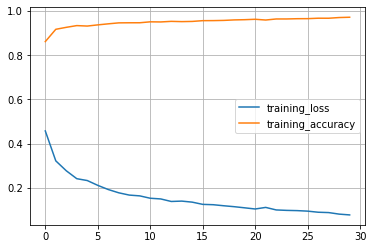

In [15]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [16]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

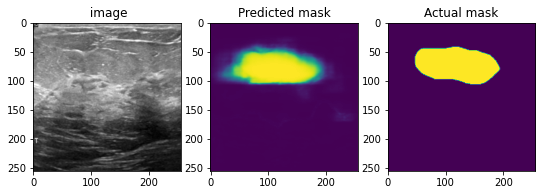

In [17]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

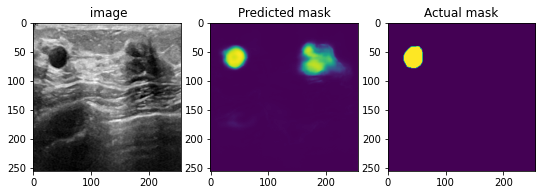

In [18]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

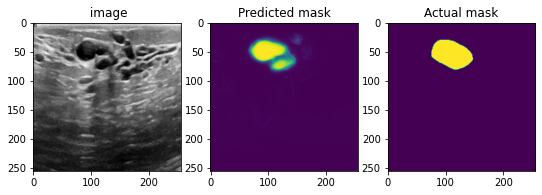

In [19]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

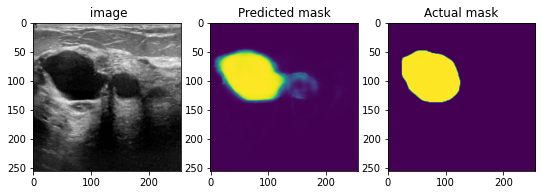

In [20]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

In [21]:
myTransformer.save('BreastCancerSegmentor.h5')